# Programming Assignment: Numerical Optimization for Logistic Regression.

### Name: Keshav Patel


In [73]:
import plotly.io as pio
pio.renderers.default='notebook'
!pip install Pyppeteer
!pyppeteer-install


chromium is already installed.
zsh:1: no matches found: nbconvert[webpdf]


zsh:1: no matches found: nbconvert[webpdf]
Note: you may need to restart the kernel to use updated packages.


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Logistic/paper/logistic.pdf)

2. Read, complete, and run my code.

3. **Implement mini-batch SGD** and evaluate the performance.

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
    * Missing **the output after execution** will not be graded.
    
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo.  (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

6. On Canvas, submit the Google Drive/Dropbox/Github link to the HTML file.


## Grading criteria:

1. When computing the ```gradient``` and ```objective function value``` using a batch of samples, use **matrix-vector multiplication** rather than a FOR LOOP of **vector-vector multiplications**.

2. Plot ```objective function value``` against ```epochs```. In the plot, compare GD, SGD, and MB-SGD (with $b=8$ and $b=64$). The plot must look reasonable.

# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [59]:
from sklearn import datasets
import numpy as np

x_sparse, y = datasets.load_svmlight_file('diabetes.txt')
x = x_sparse.todense()
print('Shape of x_sparse: ' + str(x_sparse.shape))
print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x_sparse: (768, 8)
Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [60]:
# partition the data to training and test sets
n = x.shape[0] #gives size of first axis, in this rows so 768 rows
n_train = 640 #how many instances will be in training and test sets
n_test = n - n_train

rand_indices = np.random.permutation(n) #randomize training and test set examples
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1) # change y into a 2d matrix
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [61]:
# Standardization makes mean 0 and unit variance
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1] #size of 2nd axis, in this case how many columns. will standarize features on a column basis
#when you set axis =0 in calculations below, it neans you want to calculate the mean and standard deviation
#for each column across all the rows, treats each column as a seperate dataset
#then reshapes mu and sig into a 
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))
print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.00046457 -0.12643798  0.03537123 -0.05690668  0.07618429 -0.07566123
   0.03193279 -0.01909037]]
test std = 
[[1.00720397 0.86880864 0.86989171 0.94199148 1.09332529 0.93392557
  1.08818037 1.02439979]]


## 1.4. Add a dimension of all ones

In [62]:
#add dimension of 1 for bias
n_train, d = x_train.shape
#n_train stores number of rows in x_train
#d will store number of columns in x_train

x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)
#adds a column of 1s because axis = 1

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


# 2. Logistic regression model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

In [63]:
# Calculate the objective function value
# Inputs:
#     w: d-by-1 matrix: weights of each feature
#     x: n-by-d matrix: feature matrix
#     y: n-by-1 matrix: label for each of the instances (classification)
#     lam: scalar, the regularization parameter
# Return:
#     objective function value (scalar)
def objective(w, x, y, lam):
    n, d = x.shape #n tells you how many data points, d tells you how many features
    yx = numpy.multiply(y, x) # n-by-d matrix element wise multiplication, between labels and feature matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix dotproduct between yx and w. inner product of data points and weights
    #yxw calculated linear combination of features and weights, used to model log-odds (probablity of positive class)
    vec1 = numpy.exp(-yxw) # n-by-1 matrix exponential of yxw
    #vec1 transforms linear combination into a probability, probability of positive class
    vec2 = numpy.log(1 + vec1) # n-by-1 matrix natural log of vec1
    #vec2 computes log loss for each data point.used to measure error 
    loss = numpy.mean(vec2) # scalar 
    #logisitc loss is the averae of log loss across all datapoints
    reg = lam / 2 * numpy.sum(w * w) # scalar
    #reg prevents overfitting by penalizing large weights. 
    return loss + reg

In [64]:
# initialize w
d = x_train.shape[1]
w = numpy.zeros((d, 1))

# evaluate the objective function value at w
lam = 1E-6
objval0 = objective(w, x_train, y_train, lam)
print('Initial objective function value = ' + str(objval0))

Initial objective function value = 0.6931471805599453


# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ is $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [65]:
# Calculate the gradient
#gradient returns full gradient, represnts direction.magnitude of steepest increase in logistic regression objective function
#weights updated in opposite direction of gradient to minimize objective function
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     g: g: d-by-1 matrix, full gradient
def gradient(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(yxw) # n-by-1 matrix
    vec2 = numpy.divide(yx, 1+vec1) # n-by-d matrix
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w
    return g

In [66]:
# Gradient descent for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_iter: integer, the maximal iterations
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: d-by-1 matrix, the solution
#     objvals: a record of each iteration's objective value
def grad_descent(x, y, lam, stepsize, max_iter=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_iter) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_iter):
        objval = objective(w, x, y, lam)
        objvals[t] = objval
        print('Objective value at t=' + str(t) + ' is ' + str(objval))
        g = gradient(w, x, y, lam)
        w -= stepsize * g
    
    return w, objvals

Run gradient descent.

In [28]:
lam = 1E-6
stepsize = 1.0
w, objvals_gd = grad_descent(x_train, y_train, lam, stepsize)

Objective value at t=0 is 0.6931471805599453
Objective value at t=1 is 0.5940065187414814
Objective value at t=2 is 0.5538176673505883
Objective value at t=3 is 0.5323632966670608
Objective value at t=4 is 0.51909084308512
Objective value at t=5 is 0.5101906028345309
Objective value at t=6 is 0.5039212375395691
Objective value at t=7 is 0.4993563387961882
Objective value at t=8 is 0.4959513118969366
Objective value at t=9 is 0.493363599398337
Objective value at t=10 is 0.4913671862555881
Objective value at t=11 is 0.48980758382356276
Objective value at t=12 is 0.48857625492528967
Objective value at t=13 is 0.48759523207392014
Objective value at t=14 is 0.48680745605561365
Objective value at t=15 is 0.48617049802858464
Objective value at t=16 is 0.4856523667954065
Objective value at t=17 is 0.4852286438774144
Objective value at t=18 is 0.48488048709624676
Objective value at t=19 is 0.4845932152294612
Objective value at t=20 is 0.48435528910814063
Objective value at t=21 is 0.48415756790

## 3.2. Stochastic gradient descent (SGD)

Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [29]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar
    
    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

In [30]:
# SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def sgd(x, y, lam, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

Run SGD.

In [31]:
lam = 1E-6
stepsize = 0.1
w, objvals_sgd = sgd(x_train, y_train, lam, stepsize)

Objective value at epoch t=0 is 0.5425591594122026
Objective value at epoch t=1 is 0.5273171926645535
Objective value at epoch t=2 is 0.5266654383676376
Objective value at epoch t=3 is 0.5189631032875062
Objective value at epoch t=4 is 0.515934326537181
Objective value at epoch t=5 is 0.5183556066249474
Objective value at epoch t=6 is 0.5087478722162198
Objective value at epoch t=7 is 0.5097282262327766
Objective value at epoch t=8 is 0.5090128443316968
Objective value at epoch t=9 is 0.5055395725305007
Objective value at epoch t=10 is 0.5051811806913032
Objective value at epoch t=11 is 0.5044432255269621
Objective value at epoch t=12 is 0.4988011035198472
Objective value at epoch t=13 is 0.49791920469163076
Objective value at epoch t=14 is 0.49934819388379736
Objective value at epoch t=15 is 0.4966514099483404
Objective value at epoch t=16 is 0.4964883156200857
Objective value at epoch t=17 is 0.4916362067746968
Objective value at epoch t=18 is 0.49356122299765365
Objective value at e

# 4. Compare GD with SGD

Plot objective function values against epochs.

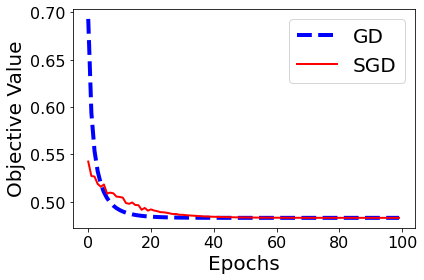

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', linewidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', linewidth=2)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Objective Value', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend([line0, line1], ['GD', 'SGD'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)

# 5. Prediction

In [33]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

In [34]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.234375


In [35]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.1796875


# 6. Mini-batch SGD (fill the code)



## 6.1. Compute the objective $Q_I$ and its gradient using a batch of samples

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [39]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: d-by-1 matrix
#     xi: b-by-d matrix
#     yi: b-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def mb_stochastic_objective_gradient(w, x, y, lam, b):
    # Random sample indices without replacement, size b 
    batch_indices = np.random.choice(len(x), size=b, replace=False)
    x_batch = x[batch_indices]
    y_batch = y[batch_indices]
    
    # Calculate objective function Q_batch
    yx_batch = y_batch * x_batch  # n_batch-by-d matrix
    yxw_batch = np.dot(yx_batch, w)  # n_batch-by-1 matrix
    loss_batch = np.log(1 + np.exp(-yxw_batch))  # n_batch-by-1 matrix
    reg = lam / 2 * np.sum(w * w)  # scalar
    obj_batch = np.mean(loss_batch) + reg  # scalar

    # Calculate stochastic gradient for the batch
    g_loss_batch = -yx_batch.T / (1 + np.exp(yxw_batch))  # d-by-n_batch matrix
    g = -np.mean(g_loss_batch, axis=1).reshape(-1, 1) + lam * w  # d-by-1 matrix

    return obj_batch, g

## 6.2. Implement mini-batch SGD

Hints:
1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_stochastic_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.


In [67]:
# Mini-Batch SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def mb_sgd(x, y, lam, b, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = np.zeros(max_epoch)  # Store the objective values
    if w is None:
        w = np.zeros((d, 1))  # Zero initialization

    num_batches = n // b  # Calculate the number of batches

    for t in range(max_epoch):
        rand_indices = np.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]

        objval = 0  # Accumulate the objective values

        for batch_index in range(num_batches):
            start = batch_index * b
            end = (batch_index + 1) * b
            x_batch = x_rand[start:end, :]  
            y_batch = y_rand[start:end, :]  

            obj_batch = 0
            g_batch = np.zeros((d, 1))

            for i in range(b):
                xi = x_batch[i, :]  # 1-by-d matrix
                yi = float(y_batch[i, :])  # Scalar
                obj, g = stochastic_objective_gradient(w, xi, yi, lam)
                obj_batch += obj
                g_batch += g
            w -= stepsize * g_batch

            objval += obj_batch

        stepsize *= 0.9  # Decrease step size
        objval /= n  # Calculate the average objective value for the epoch
        objvals[t] = objval  # Store the objective value for this epoch
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    return w, objvals


## 6.3. Run MB-SGD

In [68]:
# MB-SGD with batch size b=8
lam = 1E-6 # do not change
b = 8 # do not change
stepsize = 0.1 # you must tune this parameter

w, objvals_mbsgd8 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch t=0 is 0.5539025758009529
Objective value at epoch t=1 is 0.5323643331838661
Objective value at epoch t=2 is 0.5320933095071585
Objective value at epoch t=3 is 0.523369946143723
Objective value at epoch t=4 is 0.5304178612743917
Objective value at epoch t=5 is 0.5137191966669729
Objective value at epoch t=6 is 0.507477026795103
Objective value at epoch t=7 is 0.5153481173121339
Objective value at epoch t=8 is 0.5045838917678773
Objective value at epoch t=9 is 0.5075738355022131
Objective value at epoch t=10 is 0.5005405910769861
Objective value at epoch t=11 is 0.5024303346219491
Objective value at epoch t=12 is 0.5016361782751699
Objective value at epoch t=13 is 0.49906669902191336
Objective value at epoch t=14 is 0.49578115412219964
Objective value at epoch t=15 is 0.49713818601238435
Objective value at epoch t=16 is 0.49313370963560843
Objective value at epoch t=17 is 0.493044025058749
Objective value at epoch t=18 is 0.49275291538100385
Objective value at e

In [69]:
# MB-SGD with batch size b=64
lam = 1E-6 # do not change
b = 64 # do not change
stepsize = 0.1 # you must tune this parameter
w, objvals_mbsgd64 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch t=0 is 0.6432030203802178
Objective value at epoch t=1 is 0.5687536280379246
Objective value at epoch t=2 is 0.5363849106376227
Objective value at epoch t=3 is 0.5594556179863165
Objective value at epoch t=4 is 0.5487955839042141
Objective value at epoch t=5 is 0.5140842529352428
Objective value at epoch t=6 is 0.536646764964764
Objective value at epoch t=7 is 0.5239786028296841
Objective value at epoch t=8 is 0.5136087784167678
Objective value at epoch t=9 is 0.5125423661938178
Objective value at epoch t=10 is 0.5063466982642586
Objective value at epoch t=11 is 0.5118635380879366
Objective value at epoch t=12 is 0.5012754520953011
Objective value at epoch t=13 is 0.5001388896729891
Objective value at epoch t=14 is 0.5012775381328851
Objective value at epoch t=15 is 0.49505552584068646
Objective value at epoch t=16 is 0.49114222259761375
Objective value at epoch t=17 is 0.4956927786122366
Objective value at epoch t=18 is 0.49545665278798373
Objective value at e

# 7. Plot and compare GD, SGD, and MB-SGD

You are required to compare the following algorithms:

- Gradient descent (GD)

- SGD

- MB-SGD with b=8

- MB-SGD with b=64

Follow the code in Section 4 to plot ```objective function value``` against ```epochs```. There should be four curves in the plot; each curve corresponds to one algorithm.

Hint: Logistic regression with $\ell_2$-norm regularization is a strongly convex optimization problem. All the algorithms will converge to the same solution. **In the end, the ``objective function value`` of the 4 algorithms will be the same. If not the same, your implementation must be wrong. Do NOT submit wrong code and wrong result!**

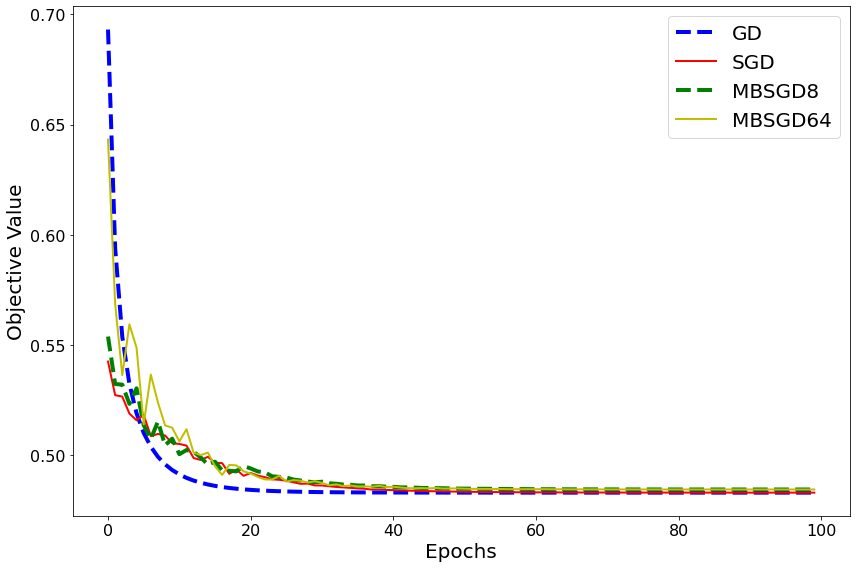

In [70]:
# Plot the objective function value against epochs
fig = plt.figure(figsize=(12,8))
epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))
epochs_mbsgd8 = range(len(objvals_mbsgd8))
epochs_mbsgd64 = range(len(objvals_mbsgd64))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', linewidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', linewidth=2)
line2, = plt.plot(epochs_mbsgd8, objvals_mbsgd8, '--g', linewidth=4)
line3, = plt.plot(epochs_mbsgd64, objvals_mbsgd64, '-y', linewidth=2)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Objective Value', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend([line0, line1, line2, line3], ['GD', 'SGD', 'MBSGD8', 'MBSGD64'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)